## Introduction

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, I have developed a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**


## Table of Contents
1. Importing dependencies
2. Importing dataset
3. Preprocessing Text
4. Analysing data
5. Splitting data
6. TF-IDF Vectoriser
7. Transforming Dataset
8. Creating and Evaluating Models
    * LinearSVC Model
    * Logistic Regression Model
    * Multinomial Naive Bayes model
9. Using the Model

## Importing Dependencies

In [1]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Importing dataset
The dataset being used is the **sentiment140 dataset**(taken from kaggle). It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
*[The training data isn't perfectly categorised as it has been created by **tagging the text according to the emoji present**. So, any model built using this dataset may have **lower than expected accuracy, since the dataset isn't perfectly categorised.**]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

This description of the dataset has been taken from kaggle where the data has been explained and distinguished.

We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Text(0.5, 1.0, 'distribution of sentiments in the dataset')

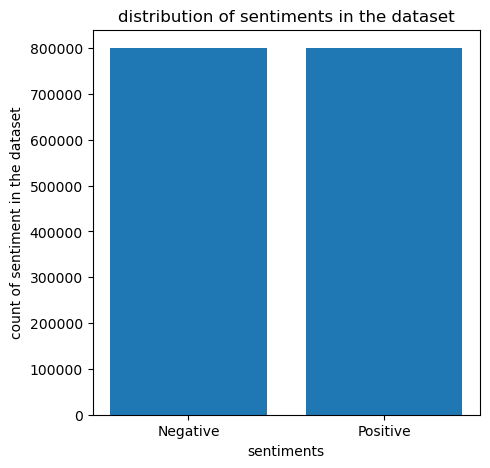

In [3]:
categories = ['Negative', 'Positive']
value_counts = dataset['sentiment'].value_counts()
values = value_counts.index.tolist()
for i in values:
    if i== 0:
        values[i]="Negative"
    else:
        values[i]="Positive"
frequencies = value_counts.tolist()
# print(values)
plt.figure(figsize=(5,5))
plt.bar(values, frequencies)
plt.xlabel('sentiments')
plt.ylabel('count of sentiment in the dataset')
plt.title('distribution of sentiments in the dataset')

## Preprocess Text
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
len(emojis)

32

In [5]:
from nltk.corpus import stopwords
stopwords= set(stopwords.words("english"))
len(stopwords)

179

In [6]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets and non numerics with whitespace
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [7]:
# had to download nltk omw-1.4 for wordnetlemmatizer
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 106 seconds


## Analysing the data
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets.

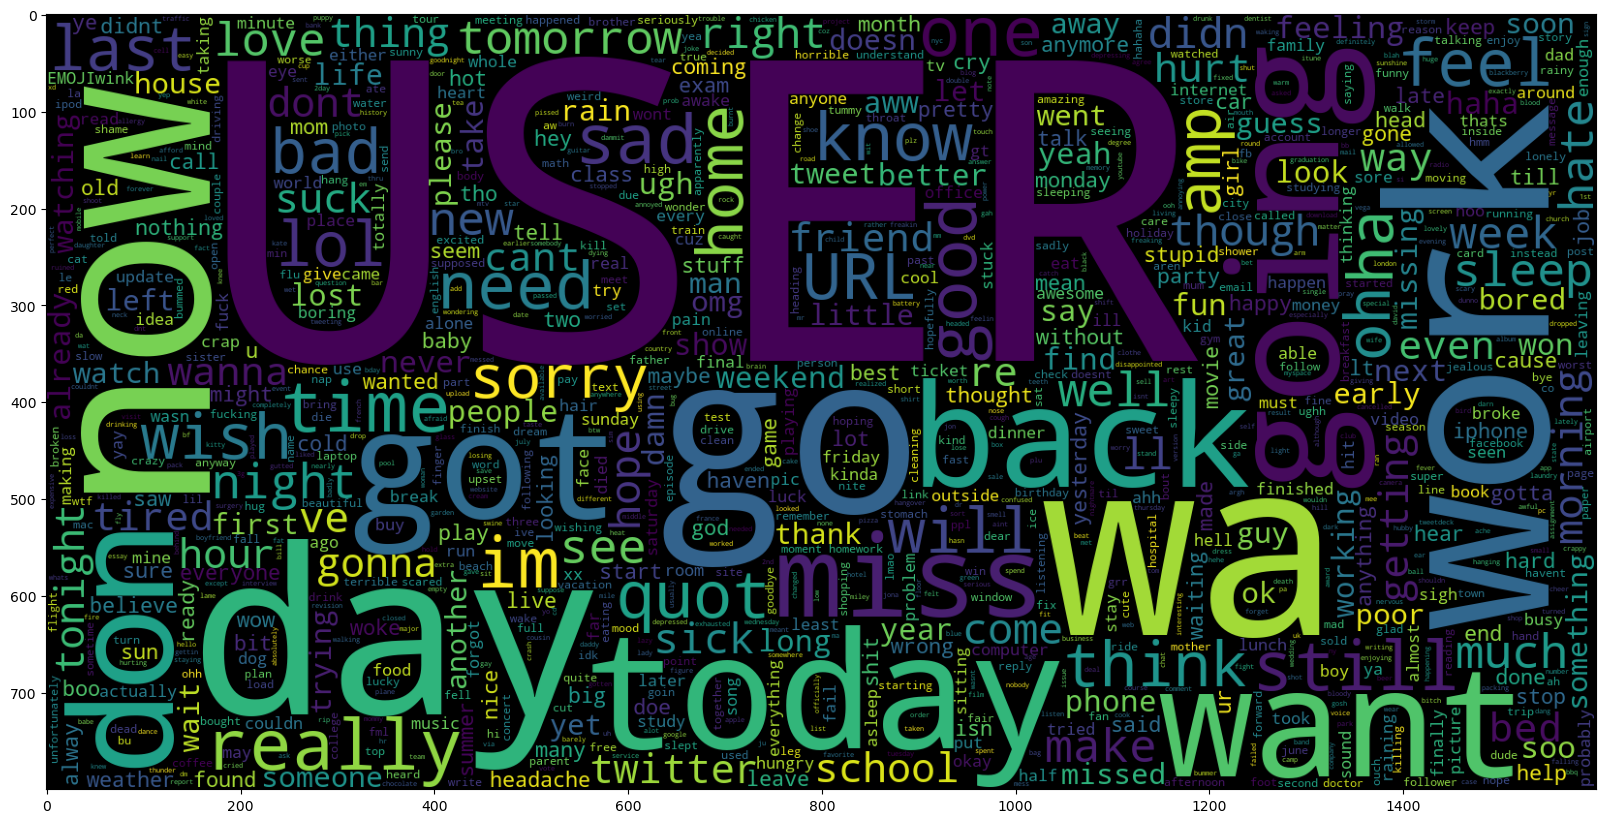

In [8]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

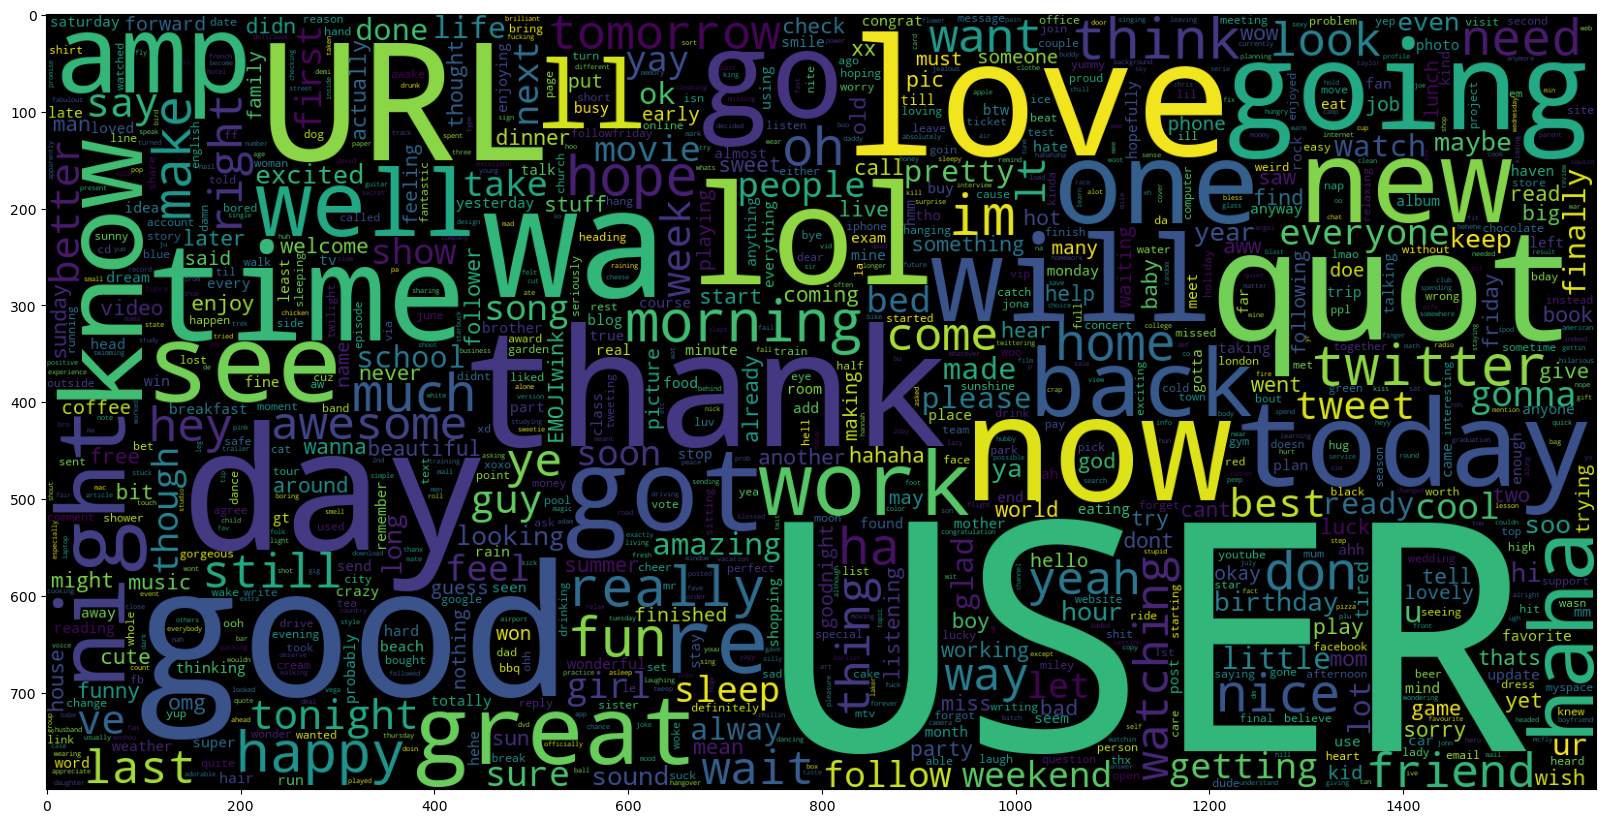

In [9]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting the Data
The Preprocessed Data is divided into 2 sets of data: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## TF-IDF Vectoriser

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 


In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
# i have taken max features to be 5 lakh, you can vary this number to check the model's accuracy 
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


### Tranforming the dataset
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [12]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem: 
* **Multionomial Naive Bayes (MultinomialNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [13]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    print("accuracy score of the model" ,  accuracy_score(y_test,y_pred)*100 , "%" )
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print("confusion matrix -")
    print(cf_matrix)


### LinearSVC Model

In [14]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

accuracy score of the model 81.845 %
confusion matrix -
[[32378  7611]
 [ 6913 33098]]


### Logistic Regression Model

In [15]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

accuracy score of the model 82.85375 %
confusion matrix -
[[32750  7239]
 [ 6478 33533]]


### Multinomial Naive Bayes Model

In [16]:
MultinomialNBmodel = MultinomialNB(alpha = 2) 
#alpha represents the additive(Laplace) smoothing parameter to handle zero probabilitites or features that havent been seen in the training dataset
# more the value of the alpha more the smoothening parameter and less overfitting
MultinomialNBmodel.fit(X_train, y_train)
model_Evaluate(MultinomialNBmodel)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     39989
           1       0.82      0.80      0.81     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

accuracy score of the model 80.81625 %
confusion matrix -
[[32782  7207]
 [ 8140 31871]]


We can clearly see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves nearly **82.8% accuracy** while classifying the sentiment of a tweet.

Although it should also be noted that the **MultinomialNB Model** is the fastest to train and predict on. It also achieves **80.8% accuracy** while calssifying.

## Using the Model

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.

In [17]:
text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so great. I am dying."]

In [18]:
textdata = vectoriser.transform(preprocess(text))
sentiment = MultinomialNBmodel.predict(textdata)

In [19]:
# example predictions on text not in dataset
data = []
for i in range(len(sentiment)):
    if i==0:
        print(text[i], "    ", "Sentiment -> Negative" )
    else:
        print(text[i], "    ", "Sentiment -> Postive" )


I hate twitter      Sentiment -> Negative
May the Force be with you.      Sentiment -> Postive
Mr. Stark, I don't feel so great. I am dying.      Sentiment -> Postive
